In [1]:
import tensorflow as tf
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# Define directory containing all your data
data_dir = r"E:\MAIN PROJECT\FILTERD CODES\data splitting\scalogram data\ECG_scalogram_divided"

# Define image dimensions
target_size = (224, 224)

batch_size = 64

# Create data generator with augmentation for training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # Set up data generators for training, validation, and test sets

# Create data generator for training data
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # Shuffle the data
    subset='training'  # Use training subset
)

# Create data generator for validation data
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # Do not shuffle the data for validation
    subset='validation'  # Use validation subset
)



Found 2782 images belonging to 2 classes.
Found 695 images belonging to 2 classes.


In [2]:
import tensorflow as tf

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + tf.keras.backend.epsilon()))

In [15]:
# Load pre-trained GoogleNet model without the top (classification) layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Add custom top layers for your binary classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Combine base model with custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1_score])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    filepath="E:\MAIN PROJECT\\FILTERD CODES\\data splitting\\trained models\\GoogLeNet\\GoogLeNet_ECG\\GoogLeNet_ECG_epoch_{epoch:02d}.keras",  # Save the model with the epoch number in the filename
    save_weights_only=False,  # Save the entire model (architecture, weights, and training configuration)
    save_best_only=False,  # Save the model after each epoch, regardless of performance
    monitor='val_loss',  # Quantity to monitor on the validation set
    mode='min',  # Mode can be 'min' or 'max' depending on whether you want to minimize or maximize the monitored quantity
    verbose=1
)


# Define a callback for early stopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Quantity to monitor on the validation set
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

# Train the model using data generators
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, early_stopping_callback]

)


Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 0.5593 - accuracy: 0.7412 - precision: 0.3297 - recall: 0.2906 - f1_score: 0.2914
Epoch 1: saving model to E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\GoogLeNet\GoogLeNet_ECG\GoogLeNet_ECG_epoch_01.keras
44/44 [==============================] - 221s 5s/step - loss: 0.5593 - accuracy: 0.7412 - precision: 0.3297 - recall: 0.2906 - f1_score: 0.2914 - val_loss: 29.2353 - val_accuracy: 0.7108 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8785 - precision: 0.7735 - recall: 0.8377 - f1_score: 0.7935
Epoch 2: saving model to E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\GoogLeNet\GoogLeNet_ECG\GoogLeNet_ECG_epoch_02.keras
44/44 [==============================] - 198s 5s/step - loss: 0.2995 - accuracy: 0.8785 - precision: 0.7735 - recall: 0.8377 - f1_score: 0.7935 - val_loss:

In [4]:
from tensorflow.keras.models import load_model
GoogLeNet_ECG = load_model(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\GoogLeNet\GoogLeNet_ECG\GoogLeNet_ECG_epoch_19.keras",custom_objects={'precision': precision, 'recall': recall, 'f1_score': f1_score})

44/44 [==============================] - 52s 1s/step


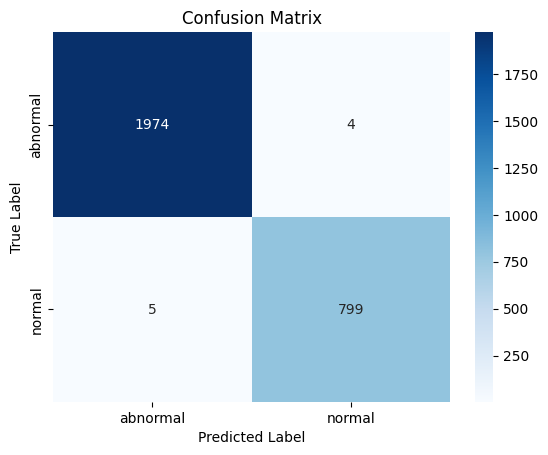

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1978
           1       1.00      0.99      0.99       804

    accuracy                           1.00      2782
   macro avg       1.00      1.00      1.00      2782
weighted avg       1.00      1.00      1.00      2782



In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have a trained model named 'model' and validation generator 'val_generator'

# Predict the labels on the validation set
y_true_train = train_generator.classes
y_pred_prob_train= GoogLeNet_ECG.predict(train_generator)
y_pred_train = np.round(y_pred_prob_train)  # Convert probabilities to binary predictions

# Calculate the confusion matrix
cm_train = confusion_matrix(y_true_train, y_pred_train)

# Visualize the confusion matrix with values
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['abnormal', 'normal'], yticklabels=['abnormal', 'normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_train, y_pred_train))

In [7]:
# Assuming the classes are labeled as 0 and 1
class_0_probabilities = y_pred_prob_train[:, 0]  # Probabilities for class 0
class_1_probabilities = 1 - class_0_probabilities  # Probabilities for class 1

# Print the probabilities for both classes
print("Probabilities for class 0:", class_0_probabilities)
print("Probabilities for class 1:", class_1_probabilities)

Probabilities for class 0: [5.6017766e-04 1.2393148e-03 2.1969299e-03 ... 9.9994975e-01 9.9999881e-01
 9.9999052e-01]
Probabilities for class 1: [9.9943984e-01 9.9876070e-01 9.9780309e-01 ... 5.0246716e-05 1.1920929e-06
 9.4771385e-06]


11/11 [==============================] - 11s 992ms/step


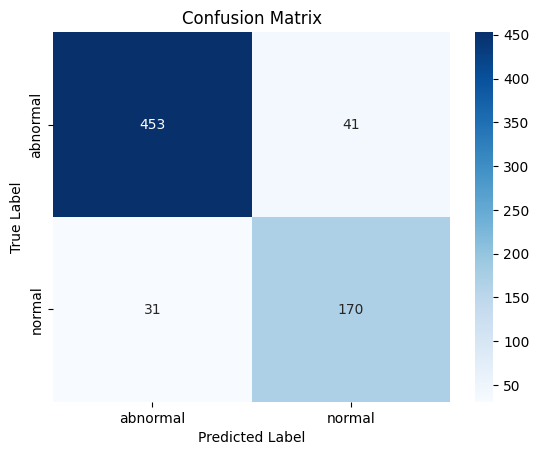

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       494
           1       0.81      0.85      0.83       201

    accuracy                           0.90       695
   macro avg       0.87      0.88      0.88       695
weighted avg       0.90      0.90      0.90       695



In [8]:
import numpy as np
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have a trained model named 'model' and validation generator 'val_generator'

# Predict the labels on the validation set
y_true_val = validation_generator.classes
y_pred_prob_val = GoogLeNet_ECG.predict(validation_generator)
y_pred_val = np.round(y_pred_prob_val)  # Convert probabilities to binary predictions

# Calculate the confusion matrix
cm_val = confusion_matrix(y_true_val, y_pred_val)

# Visualize the confusion matrix with values
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['abnormal', 'normal'], yticklabels=['abnormal', 'normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_val, y_pred_val))

In [36]:
print(cm_train,cm_val)

[[1974    4]
 [   5  799]] [[453  41]
 [ 31 170]]


In [9]:
# Assuming the classes are labeled as 0 and 1
class_0_probabilities = y_pred_prob_val[:, 0]  # Probabilities for class 0
class_1_probabilities = 1 - class_0_probabilities  # Probabilities for class 1

# Print the probabilities for both classes
print("Probabilities for class 0:", class_0_probabilities)
print("Probabilities for class 1:", class_1_probabilities)

Probabilities for class 0: [2.14254561e-20 6.54784460e-21 2.04684868e-14 4.01638233e-21
 2.50535785e-20 4.08108918e-16 4.87857825e-08 6.51588573e-18
 6.50325773e-22 5.06916456e-03 2.92129248e-01 6.60748184e-02
 9.97065827e-02 6.18233010e-02 1.83013100e-02 1.00883062e-06
 3.46167838e-07 8.43785415e-07 3.13979035e-06 2.59553485e-06
 1.42128158e-06 2.49549686e-07 4.32594192e-07 6.82449806e-03
 8.00591186e-02 2.39524711e-03 1.26671806e-01 7.96629310e-01
 3.01122572e-02 9.99099202e-03 2.67751157e-01 4.66860861e-01
 3.26062483e-03 9.98753667e-01 9.86232996e-01 9.99577403e-01
 2.79967517e-01 8.27522039e-01 8.73513341e-01 7.37957598e-04
 9.90520954e-01 6.07818127e-01 9.77845609e-01 9.97027755e-01
 6.24000967e-01 9.66873229e-01 9.98895109e-01 3.47328140e-08
 4.72076244e-05 8.09772173e-05 3.11186777e-05 3.65994492e-06
 1.08416343e-05 2.03633990e-05 7.16869195e-04 2.03197030e-03
 6.30415860e-04 5.13883540e-04 3.82254191e-04 4.76631307e-04
 4.09298547e-04 1.46841200e-03 6.44639658e-04 1.00553746e-

In [1]:
import re

# Open the text document in read mode
with open(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\GoogLeNet\GoogLeNet_ECG\GoogLeNet_ECG.txt", 'r') as file:
    # Read the entire contents of the file
    text = file.read()

# Regular expression pattern to match accuracy values
pattern1 = r"accuracy: (\d+\.\d+)"
pattern2 = r"val_accuracy: (\d+\.\d+)"
pattern3 = r"loss: (\d+\.\d+)"
pattern4 = r"val_loss: (\d+\.\d+)"


# Find all accuracy values using regex
train_accuracy1 = re.findall(pattern1, text)
val_accuracy = re.findall(pattern2, text)
train_loss1 = re.findall(pattern3, text)
val_loss = re.findall(pattern4, text)

# Convert accuracy values to float
train_accuracy1 = [float(value) for value in train_accuracy1]
val_accuracy = [float(value) for value in val_accuracy]
train_loss1 = [float(value) for value in train_loss1]
val_loss = [float(value) for value in val_loss]

In [27]:
len(train_accuracy)

21

In [2]:
train_accuracy=[]
train_loss=[]
i=-2
while i<60:
    train_accuracy.append(train_accuracy1[i+3])
    train_loss.append(train_loss1[i+3])
    i+=3

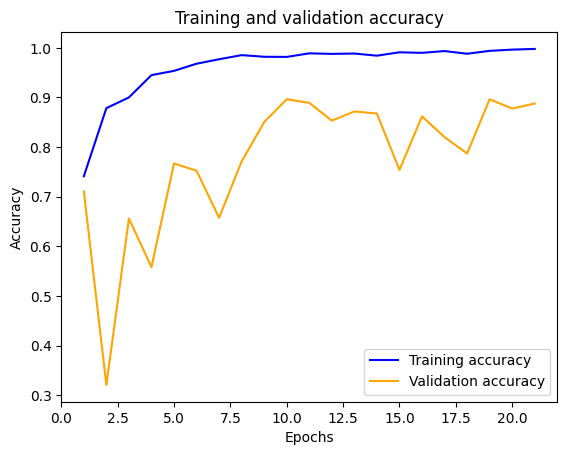

In [29]:
import matplotlib.pyplot as plt
# Plot the epoch vs accuracy curve
epochs = range(1, 22)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

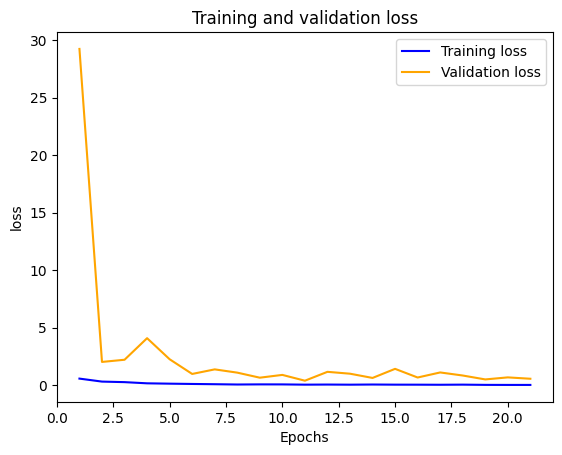

In [3]:
import matplotlib.pyplot as plt
# Plot the epoch vs accuracy curve
epochs = range(1, 22)
plt.plot(epochs, train_loss ,'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [33]:
def calculate_metrics(confusion_matrix):
    # Extract values from confusion matrix
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[1][0]
    FN = confusion_matrix[0][1]
    TN = confusion_matrix[1][1]
    
    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return precision, recall, f1_score, accuracy,specificity

In [38]:
cm_fused_val= [[453,  41],[ 31 ,170]]
# Calculate metrics
val_precision, val_recall, val_f1_score, val_accuracy, val_specificity = calculate_metrics(cm_fused_val)

# Print results
print("Precision:", val_precision)
print("Recall (Sensitivity):", val_recall)
print("F1 Score:", val_f1_score)
print("Accuracy:", val_accuracy)
print("specificity:",val_specificity)

Precision: 0.9359504132231405
Recall (Sensitivity): 0.917004048582996
F1 Score: 0.9263803680981596
Accuracy: 0.8964028776978418
specificity: 0.845771144278607


In [37]:
cm_ecg_train= [[1974  ,  4],[   5 , 799]]
# Calculate metrics
train_precision, train_recall, train_f1_score, train_accuracy, train_specificity = calculate_metrics(cm_ecg_train)

# Print results
print("Precision:", train_precision)
print("Recall (Sensitivity):", train_recall)
print("F1 Score:", train_f1_score)
print("Accuracy:", train_accuracy)
print("specificity:",train_specificity)

Precision: 0.9974734714502274
Recall (Sensitivity): 0.9979777553083923
F1 Score: 0.9977255496588324
Accuracy: 0.996764917325665
specificity: 0.9937810945273632


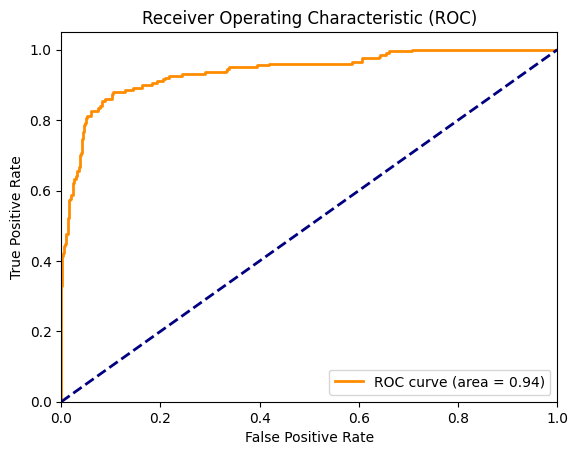

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

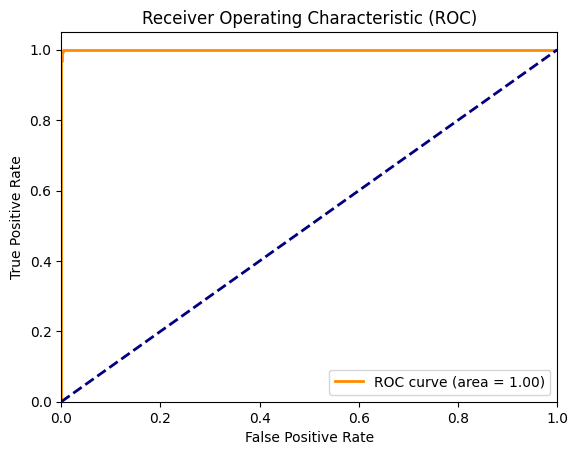

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
y_true_train=train_generator.classes
fpr, tpr, thresholds = roc_curve(y_true_train, y_pred_prob_train)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

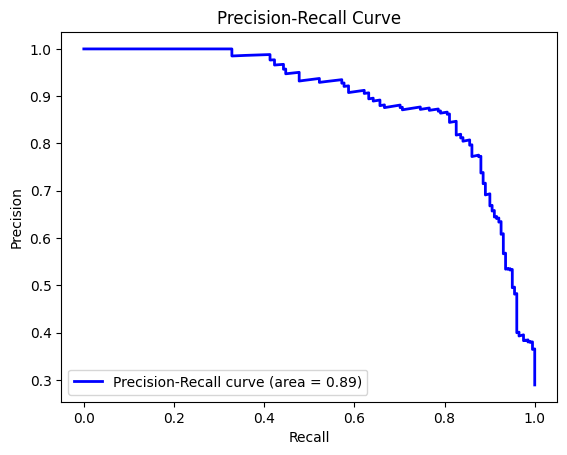

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
y_true_val=validation_generator.classes
precision, recall, thresholds = precision_recall_curve(y_true_val, y_pred_prob_val)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

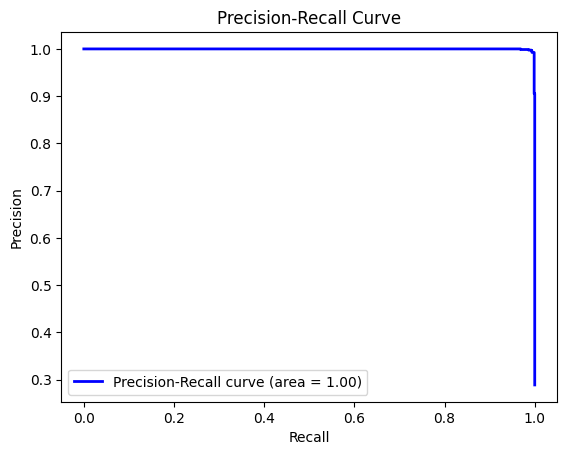

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true_train, y_pred_prob_train)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()